# Autotalker Multimodal

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 24.04.2023
- **Date of Last Modification:** 05.05.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../autotalker")
sys.path.append("../utils")

In [3]:
import os

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scib
import scvi
import squidpy as sq

from autotalker.benchmarking import compute_clisis, compute_cas
from autotalker.models import Autotalker
from autotalker.utils import get_gene_annotations, generate_multimodal_pairing_dict, add_multimodal_mask_to_adata
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps,
                              get_unique_genes_from_gp_dict)

from color_utils import (latent_cluster_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_rna_colors,
                         spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors)

Global seed set to 0
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.2.3', 51048), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.2.3', 51058), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=66, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('192.168.2.3', 51060), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_downl

### 1.2 Define Parameters

In [4]:
dataset = "spatial_atac_rna_seq_mouse_embryo_and_brain_batch3"
spatial_key = "spatial"
n_neighbors = 8
adj_key = "spatial_connectivities"
n_hvg = 3000
counts_key = "counts"
condition_key = "batch"

nichenet_keep_target_genes_ratio = 0.01
nichenet_max_n_target_genes_per_gp = 25344
include_mebocost_gps = True
mebocost_species = "mouse"
filter_genes = True
gp_filter_mode = "subset"
combine_overlap_gps = True
overlap_thresh_source_genes = 0.9
overlap_thresh_target_genes = 0.9
overlap_thresh_genes = 0.9
gp_targets_mask_key = "autotalker_gp_targets"
gp_sources_mask_key = "autotalker_gp_sources"
gp_names_key = "autotalker_gp_names"
cond_embed_injection = ["gene_expr_decoder",
                        "chrom_access_decoder"]
active_gp_names_key = "autotalker_active_gp_names"
latent_key = "autotalker_latent"
active_gp_thresh_ratio = 0.05
gene_expr_recon_dist = "nb"
n_layers_encoder = 1
conv_layer_encoder = "gcnconv"
log_variational = True
node_label_method = "one-hop-norm"
filter_peaks = True
min_cell_peak_thresh_ratio = 0.0005 # 0.05%
n_epochs = 100
n_epochs_all_gps = 25
n_epochs_no_cond_contrastive = 0
lr = 0.001
lambda_edge_recon = 5000000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 30.
lambda_cond_contrastive = 0.
contrastive_logits_ratio = 0.015625
lambda_group_lasso = 0.
lambda_l1_masked = 0.
edge_batch_size = 4096
node_batch_size = None
mlflow_experiment_id = None

In [5]:
srt_data_gold_folder_path = "../datasets/srt_data/gold"
figure_folder_path = f"../figures"
ga_data_folder_path = "../datasets/ga_data"
gp_data_folder_path = "../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
gtf_file_path = ga_data_folder_path + "/gencode.vM32.chr_patch_hapl_scaff.annotation.gtf.gz"

# Create required directories
os.makedirs(gp_data_folder_path, exist_ok=True)
os.makedirs(srt_data_gold_folder_path + "/results", exist_ok=True)

## 2. Autotalker Model

### 2.1 Prepare Gene Program Mask

In [6]:
print("Preparing the gene program mask...")
# OmniPath gene programs
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=False,
    file_path=omnipath_lr_interactions_file_path,
    plot_gp_gene_count_distributions=False)

omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

# NicheNet gene programs
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_genes_ratio=nichenet_keep_target_genes_ratio,
    max_n_target_genes_per_gp=nichenet_max_n_target_genes_per_gp,
    load_from_disk=True,
    save_to_disk=False,
    file_path=nichenet_ligand_target_mx_file_path,
    plot_gp_gene_count_distributions=False)

nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

# Combine gene programs into one dictionary
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)

if filter_genes:
    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + nichenet_source_genes))

# Mebocost gene programs
if include_mebocost_gps:
    mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
    species=mebocost_species,
    genes_uppercase=True,
    plot_gp_gene_count_distributions=False)
    
    mebocost_genes = get_unique_genes_from_gp_dict(
        gp_dict=mebocost_gp_dict,
        retrieved_gene_entities=["sources", "targets"])

    combined_gp_dict.update(mebocost_gp_dict)
    
    if filter_genes:
        # Update gene program relevant genes
        gp_relevant_genes = list(set(gp_relevant_genes + mebocost_genes))
    
# Filter and combine gene programs
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode=gp_filter_mode,
    combine_overlap_gps=combine_overlap_gps,
    overlap_thresh_source_genes=overlap_thresh_source_genes,
    overlap_thresh_target_genes=overlap_thresh_target_genes,
    overlap_thresh_genes=overlap_thresh_genes,
    verbose=False)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Preparing the gene program mask...
Number of gene programs before filtering and combining: 1725.
Number of gene programs after filtering and combining: 1575.


### 2.2 Load Data & Compute Spatial Neighbor Graph

In [7]:
# Read data
adata = sc.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_rna.h5ad")
adata_atac = sc.read_h5ad(
        f"{srt_data_gold_folder_path}/{dataset}_atac_preprocessed.h5ad")

# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [8]:
if filter_genes:
    print("\nFiltering genes...")
    # Filter genes and only keep ligand, receptor, metabolitye enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    if counts_key is not None:
        hvg_layer = counts_key
        if (adata.layers[counts_key].astype(int).astype(np.float32).sum() == 
        adata.layers[counts_key].sum()): # raw counts
            hvg_flavor = "seurat_v3"
        else: # log normalized counts
            hvg_flavor = "seurat"
    else:
        hvg_layer = None
        if adata.X.astype(int).astype(np.float32).sum() == adata.X.sum():
        # raw counts
            hvg_flavor = "seurat_v3"
        else: # log normalized counts
            hvg_flavor = "seurat"

    sc.pp.highly_variable_genes(
        adata,
        layer=hvg_layer,
        n_top_genes=n_hvg,
        flavor=hvg_flavor,
        batch_key=condition_key,
        subset=False)

    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
                gp_dict_genes)].sort_values()])
    print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
          "gp dict.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")


Filtering genes...
Starting with 22914 genes.
Keeping 22914 genes after filtering genes with expression in 0 cells.
Keeping 4962 highly variable or gene program relevant genes.
Keeping 4267 genes after filtering genes not in gp dict.

Filtering peaks...
Starting with 121068 peaks.
Keeping 121068 peaks after filtering peaks with counts in less than 4 cells.


### 2.4 Annotate Genes

In [9]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

### 2.5 Add Gene Program Mask to Data

In [10]:
# Add the gene program dictionary as binary masks to the adata for model 
# training
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    genes_uppercase=True,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None,
    filter_genes_not_in_masks=False)

### 2.6 Add Chromatin Accessibility Mask to Data

In [11]:
gene_peak_dict = generate_multimodal_pairing_dict(
    adata,
    adata_atac)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 88936 is still running
  _warn("subprocess %s is still running" % self.pid,
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 88937 is still running
  _warn("subprocess %s is still running" % self.pid,


window_graph:   0%|          | 0/4222 [00:00<?, ?it/s]

In [12]:
adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

Keeping 19520 peaks after filtering peaks with no matching genes in gp mask.


### 2.7 Initialize, Train & Save Model

In [13]:
# Determine dimensionality of hidden encoder
n_hidden_encoder = len(adata.uns[gp_names_key])

# Determine dimensionality of conditional embedding (in case injected)
n_cond_embed = len(adata.uns[gp_names_key])

In [ ]:
1 / 0

In [ ]:
import gc
gc.collect()
import torch
torch.cuda.empty_cache()

In [14]:
# Initialize model
model = Autotalker(adata,
                   adata_atac,
                   counts_key=counts_key,
                   adj_key=adj_key,
                   condition_key=condition_key,
                   cond_embed_injection=cond_embed_injection,
                   n_cond_embed=n_cond_embed,
                   gp_names_key=gp_names_key,
                   active_gp_names_key=active_gp_names_key,
                   gp_targets_mask_key=gp_targets_mask_key,
                   gp_sources_mask_key=gp_sources_mask_key,
                   latent_key=latent_key,
                   active_gp_thresh_ratio=active_gp_thresh_ratio,
                   gene_expr_recon_dist=gene_expr_recon_dist,
                   n_layers_encoder=n_layers_encoder,
                   conv_layer_encoder=conv_layer_encoder,
                   n_hidden_encoder=n_hidden_encoder,
                   log_variational=log_variational,
                   node_label_method=node_label_method)

/home/sbirk/storage/autotalker-reproducibility/notebooks/../../autotalker/autotalker/models/autotalker.py:304: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/torch/csrc/utils/tensor_new.cpp:201.)
  self.ca_mask_ = torch.sparse_coo_tensor(


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb, include_chrom_access_recon_loss: True, chrom_access_recon_dist: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.05
LOG VARIATIONAL -> True
CONDITIONAL EMBEDDING INJECTION -> ['gene_expr_decoder', 'chrom_access_decoder']
ENCODER -> n_input: 23742, n_cond_embed_input: 0, n_layers: 1, n_hidden: 1479, n_latent: 1479, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> n_cond_embed_input: 0, n_cond_embed_output: 1479, dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1479, n_cond_embed_input: 1479, n_addon_input: 0, n_output: 8444
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1479, n_cond_embed_input: 1479, n_addon_input: 0, n_output: 39040
ONE HOP GCN NORM NODE LABEL AGGREGATOR -> self_loops: True


In [15]:
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 100.

In [16]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            n_epochs_no_cond_contrastive=n_epochs_no_cond_contrastive,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_cond_contrastive=lambda_cond_contrastive,
            contrastive_logits_ratio=contrastive_logits_ratio,
            lambda_group_lasso=lambda_group_lasso,
            lambda_l1_masked=lambda_l1_masked,
            edge_batch_size=edge_batch_size,
            node_batch_size=node_batch_size,
            mlflow_experiment_id=mlflow_experiment_id,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 33399
Number of validation edges: 3711

--- MODEL TRAINING ---
Epoch 1/100 |--------------------| 1.0% val_auroc_score: 0.8813; val_auprc_score: 0.8945; val_best_acc_score: 0.5206; val_best_f1_score: 0.6748; train_kl_reg_loss: 7725.9965; train_edge_recon_loss: 347963.8889; train_gene_expr_recon_loss: 522773.2292; train_masked_gp_l1_reg_loss: 0.0000; train_group_lasso_reg_loss: 0.0000; train_chrom_access_recon_loss: 599245.9583; train_global_loss: 1477709.0694; train_optim_loss: 1477709.0694; val_kl_reg_loss: 6442.8789; val_edge_recon_loss: 406277.0000; val_gene_expr_recon_loss: 470365.0938; val_masked_gp_l1_reg_loss: 0.0000; val_group_lasso_reg_loss: 0.0000; val_chrom_access_recon_loss: 576580.8750; val_global_loss: 1459665.8750; val_optim_loss: 1459665.8750
Epoch 2/100 |--------------------| 2.0% val_auroc_score: 0.8808; val_auprc_score: 0.8915; val_best_acc_score: 0.

## 3. Analyze Results

In [22]:
sc.pp.neighbors(model.adata,
                use_rep=latent_key)
sc.tl.umap(model.adata)
sc.tl.leiden(model.adata,
             key_added="autotalker_cluster",
             resolution=0.3)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


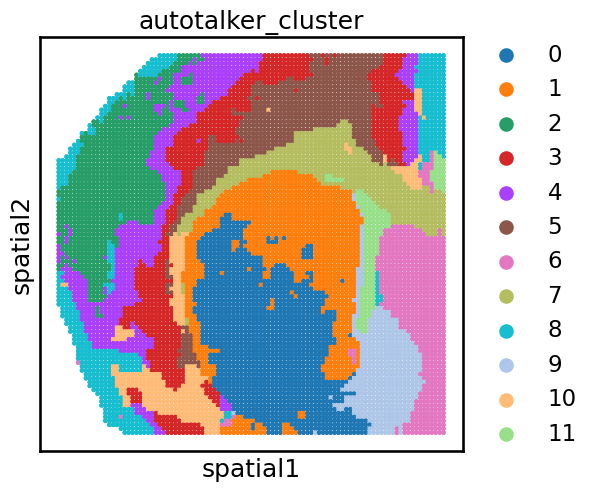

In [24]:
del(adata.uns["autotalker_cluster_colors"])
sq.pl.spatial_scatter(model.adata, color="autotalker_cluster", shape=None)        

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


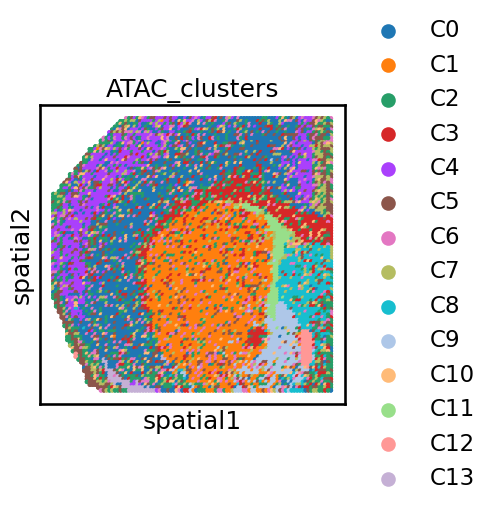

In [20]:
sq.pl.spatial_scatter(model.adata, color="ATAC_clusters", shape=None)  

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:822: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


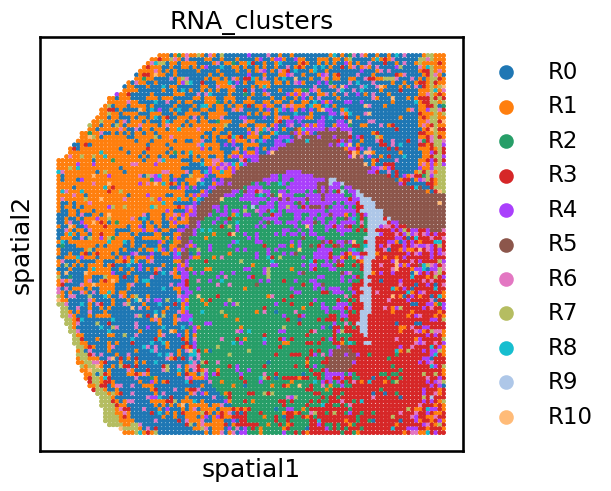

In [21]:
sq.pl.spatial_scatter(model.adata, color="RNA_clusters", shape=None)  

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["autotalker_cluster"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("Autotalker (Multimodal): Latent Space Cluster Annotations", size=20, pad=15)

In [ ]:
sq.pl.spatial_scatter(model.adata, color="RNA_clusters", shape=None)        

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["RNA_clusters"],
                 palette=spatial_atac_rna_seq_mouse_embryo_and_brain_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

In [ ]:
sq.pl.spatial_scatter(model.adata, color="ATAC_clusters", shape=None)        

In [ ]:
model.adata.obs["ATAC_clusters"].unique()

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(model.adata,
                 #groups="Allantois",
                 color=["ATAC_clusters"],
                 palette=spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

## 4. Benchmarks

### 4.1 SCVI Benchmark (RNA)

In [ ]:
# Setup adata
scvi.model.SCVI.setup_anndata(adata,
                              layer=counts_key,
                              batch_key=condition_key)

# Initialize model
# Use hyperparams that provenly work well on integration tasks
model = scvi.model.SCVI(adata,
                        n_layers=2,
                        n_latent=30,
                        gene_likelihood="nb")

# Train model
model.train()

# Store latent representation
adata.obsm["scvi_latent"] = model.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata, use_rep="scvi_latent")
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="scvi_cluster", resolution=1.)

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 #groups="Allantois",
                 color=["scvi_cluster"],
                 #palette=spatial_atac_rna_seq_mouse_embryo_and_brain_cell_type_colors,
                 legend_fontsize=12,
                 size=240000/len(adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

In [ ]:
# Plot UMAP with cell type annotations
fig = sc.pl.umap(adata,
                 #groups="Allantois",
                 color=["leiden"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(model.adata),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("One-Shot Integration: Latent Space Cell Type Annotations", size=20, pad=15)

In [ ]:
sq.pl.spatial_scatter(adata, color="scvi_cluster", shape=None)        

In [ ]:
sq.pl.spatial_scatter(adata, color="RNA_clusters", shape=None)        

In [ ]:
del(adata.uns["RNA_clusters_colors"])

In [ ]:
sq.pl.spatial_scatter(adata,
                      color="RNA_clusters",
                      shape=None)        

### 4.2 PeakVI Benchmark (ATAC)

In [ ]:
# Setup adata
scvi.model.SCVI.setup_anndata(adata_atac,
                              layer=counts_key,
                              batch_key=condition_key)

# Initialize model
pvi = scvi.model.SCVI(adata_atac,
                      gene_likelihood="nb")

# Train model
pvi.train()

# Store latent representation
adata_atac.obsm["pvi_latent"] = pvi.get_latent_representation()

In [ ]:
# Setup adata
scvi.model.PEAKVI.setup_anndata(adata_atac,
                                layer=counts_key,
                                batch_key=condition_key)

# Initialize model
pvi = scvi.model.PEAKVI(adata_atac)

# Train model
pvi.train()

# Store latent representation
adata_atac.obsm["pvi_latent"] = pvi.get_latent_representation()

In [ ]:
sc.pp.neighbors(adata_atac, use_rep="pvi_latent")
sc.tl.umap(adata_atac)
sc.tl.leiden(adata_atac, key_added="pvi_cluster", resolution=1.)

In [ ]:
# NB
# Plot UMAP with latent cluster annotations
fig = sc.pl.umap(adata_atac,
                 color=["pvi_cluster"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space Cluster Annotations", size=20, pad=15)

In [ ]:
# NB
# Plot UMAP with latent cluster annotations
fig = sc.pl.umap(adata_atac,
                 color=["pvi_cluster"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space Cluster Annotations", size=20, pad=15)

In [ ]:
# NB
# Plot UMAP with latent cluster annotations
fig = sc.pl.umap(adata_atac,
                 color=["pvi_cluster"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space Cluster Annotations", size=20, pad=15)

In [ ]:
# NB
sq.pl.spatial_scatter(adata_atac, color="pvi_cluster", shape=None)

In [ ]:
# NB
sq.pl.spatial_scatter(adata_atac, color="pvi_cluster", shape=None)        

In [ ]:
# NB
sq.pl.spatial_scatter(adata_atac, color="pvi_cluster", shape=None)        

In [ ]:
# NB
sq.pl.spatial_scatter(adata_atac, color="ATAC_clusters", shape=None)        

In [ ]:
# Poisson
# Plot UMAP with latent cluster annotations
fig = sc.pl.umap(adata_atac,
                 color=["pvi_cluster"],
                 palette=latent_cluster_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space Cluster Annotations", size=20, pad=15)

In [ ]:
# Plot UMAP with given annotations
fig = sc.pl.umap(adata_atac,
                 color=["ATAC_clusters"],
                 # palette=spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space ATAC Cluster Annotations", size=20, pad=15)

In [ ]:
# Poisson
sq.pl.spatial_scatter(adata_atac, color="pvi_cluster", shape=None)        

In [ ]:
sq.pl.spatial_scatter(adata_atac, color="ATAC_clusters", shape=None)        

In [ ]:
sq.pl.spatial_scatter(adata_atac, color="pvi_cluster", shape=None)        

In [ ]:
# Plot UMAP with given annotations
fig = sc.pl.umap(adata_atac,
                 color=["Jiont_clusters"],
                 #palette=spatial_atac_rna_seq_mouse_embryo_and_brain_atac_colors,
                 legend_fontsize=12,
                 size=240000/len(adata_atac),
                 return_fig=True)
fig.set_figheight(10)
fig.set_figwidth(10)
fig.set_size_inches(15, 10)
plt.title("PeakVI: Latent Space ATAC Cluster Annotations", size=20, pad=15)

In [ ]:
del(adata_atac.uns["ATAC_clusters_colors"])
sq.pl.spatial_scatter(adata_atac, color="Jiont_clusters", shape=None)        